In [22]:
!conda install -c conda-forge -y glmnet

Solving environment: done

# All requested packages already installed.



In [23]:
!pip install imbalanced-learn


In [16]:
#!pip install glmnet_py


In [24]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy import sparse
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from scipy.sparse import coo_matrix, csr_matrix, hstack
# Plotting library
import matplotlib.pyplot as plt 

# Read in data set

* read in dataset (train.csv and train.csr) and convert it into a sparse matrix
* count the numbers of label, 0 (credible) and 1 (non-credible)
* split the dataset into train (70%) and test data set (30%) 

In [25]:
dense = pd.read_csv("./train.tsv", sep="\t")

dense['y'].value_counts()

1    181
0     17
Name: y, dtype: int64

In [26]:
dense

,y,source,topic,sentenceNum,meanWordLength,meanSentenceLength,wordscased,wordsCased,wordsCASED,wordsCaSeD,...,GI_wlbpt,GI_wlbtot,GI_wltoth,GI_wltpt,GI_wlttot,GI_wlttran,GI_work,GI_yes,GI_you,GI_total
0,1,yournewswire.com,15,9.0,4.230032,34.777778,0.834008,0.145749,0.008097,0.012146,...,0.000000,0.040000,0.074286,0.051429,0.131429,0.011429,0.108571,0.011429,0.000000,0.559105
1,1,worldtruth.tv,61,20.0,4.010327,29.050000,0.922607,0.071283,0.000000,0.006110,...,0.002865,0.060172,0.008596,0.000000,0.005731,0.000000,0.083095,0.002865,0.002865,0.600688
2,1,beforeitsnews.com,23,37.0,4.441466,30.243243,0.879121,0.100000,0.005495,0.015385,...,0.000000,0.039801,0.039801,0.001658,0.041459,0.001658,0.067993,0.003317,0.001658,0.538874
3,1,newzmagazine.com,73,20.0,4.043353,17.300000,0.809524,0.186813,0.003663,0.000000,...,0.004975,0.099502,0.024876,0.024876,0.049751,0.004975,0.084577,0.000000,0.000000,0.580925
4,1,freedomdaily.com,40,71.0,4.282853,17.577465,0.817374,0.174729,0.003949,0.003949,...,0.000000,0.034713,0.017356,0.008011,0.020027,0.001335,0.094793,0.009346,0.001335,0.600160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,0,www.theguardian.com,3,33.0,3.975687,28.666667,0.802539,0.184767,0.002821,0.009873,...,0.006110,0.069246,0.014257,0.000000,0.018330,0.006110,0.054990,0.014257,0.044807,0.519027
194,0,www.bloomberg.com,26,128.0,3.909564,19.523438,0.735124,0.245392,0.003160,0.016324,...,0.000000,0.038431,0.022418,0.004003,0.022418,0.001601,0.053643,0.028823,0.015212,0.499800
195,0,www.newyorker.com,69,47.0,3.731765,45.212766,0.855383,0.119974,0.003891,0.020752,...,0.000000,0.040084,0.034810,0.001055,0.035865,0.003165,0.058017,0.008439,0.012658,0.446118
196,0,www.politico.com,46,35.0,4.371005,25.028571,0.853994,0.139118,0.000000,0.006887,...,0.000000,0.074510,0.154902,0.011765,0.133333,0.052941,0.054902,0.005882,0.000000,0.582192


In [27]:
# read in the sparse file (i.e train.csr)


X_data = []
X_row, X_col = [], []


with open("./train.csr", "r") as f:
    lines = f.read().splitlines()
    max = 0
    row_count = 0
    for line in lines[0:]:
        parts = line.split(" ")
        label = parts[0]
        
        

        #print(parts[1:])
        for row_idx, data in enumerate(parts[1:]):
            #print(row_idx)
            #print(data)
            
            col_idx = int(data.split(":")[0]) - 1
            X_row.append(row_count)
            X_col.append(col_idx)
            X_data.append(float(data.split(":")[1]))

        row_count += 1

    #print(row_idx)
    #print(row_count)
    #print(X_row)
    
    X_col = np.array(X_col)
    X_row = np.array(X_row)
    X_data = np.array(X_data)    
    
sparse = coo_matrix((X_data, (X_row, X_col)), dtype=float)    
    
sparse

<198x3829 sparse matrix of type '<class 'numpy.float64'>'
	with 107751 stored elements in COOrdinate format>

In [28]:
# train.csv into csr matrix
csr_matrix(dense.iloc[:, 3:].to_numpy())

<198x190 sparse matrix of type '<class 'numpy.float64'>'
	with 31373 stored elements in Compressed Sparse Row format>

In [29]:
# combine train.csv and train.csr
hstack([csr_matrix(dense.iloc[:, 3:].to_numpy()), sparse])

<198x4019 sparse matrix of type '<class 'numpy.float64'>'
	with 139124 stored elements in COOrdinate format>

In [30]:
print(dense.to_numpy().shape[0])

allX = hstack([csr_matrix(dense.iloc[:, 3:].to_numpy()), sparse]).toarray() #sparse.csr_matrix(dense.iloc[:, 3:].to_numpy()).toarray() #dense.iloc[:, 3:].to_numpy()

allX.shape[1]

allY = dense.iloc[:, 0].to_numpy()
allS = dense.iloc[:, 1]
allT = dense.iloc[:, 2]



198


In [31]:
x_train, x_test, y_train, y_test = train_test_split(allX, allY, test_size = 0.30, random_state = 25)


In [32]:
print("Training records count: {}".format(x_train.shape[0]))
print("Testing records count: {}".format(x_test.shape[0]))
print("Training features count: {}".format(x_train.shape[1]))
print("Testing features count: {}".format(x_test.shape[1]))


Training records count: 138
Testing records count: 60
Training features count: 4019
Testing features count: 4019


# Prelimniary filtering

* compute Pearson correlation of each feature with the output variable 

First, we check whether feature j is present in document i by computing a binary matrix with elements bi,j =1[xi,j = 0]. 

* remove features with absolute value of the correlation coefficient lower than 5%

Therefore, we take into account class label y by computing the correlation coefficient and including each feature j such that bj = [b1,j, b2,j, . . .] satisfies |cor(bj , y)| > 0.05. The number of retained features depends on the training-test split, but we observe it to be always below 5%.

In [33]:
# function use to compute correlation
def computeCorrelaion(trainX, trainY):
    cors = []
    for i in range(trainX.shape[1]):
        cor, p = scipy.stats.pearsonr(trainX[:,i], trainY)
        cors.append(cor)    
    print(np.array(cors))
    cors = np.array(cors)
    return cors

In [34]:
# function use to filter features
def filter_features(X, cors, threshold):
    #mask = ()
    print("Original Features Counts: {}".format(X.shape[1]))
    newX = X[:, abs(cors) > threshold]
    print("Output Features Counts: {}".format(newX.shape[1]))
    #idx = mask.any(axis=0)
    #test = allX[:, ~mask]

    return newX

In [35]:
cors = computeCorrelaion(x_train, y_train)

[-0.23861084 -0.01348123 -0.00464604 ... -0.00668315  0.04806064
 -0.0138414 ]


In [36]:
print("Training Dataset")
x_train = filter_features(x_train, cors, 0.05)
print("Testing Dataset")
x_test =  filter_features(x_test, cors, 0.05)



Training Dataset
Original Features Counts: 4019
Output Features Counts: 2144
Testing Dataset
Original Features Counts: 4019
Output Features Counts: 2144


# Building a regularised classifier

* Apply a logistic regression model implemented in glmnet

In [37]:
from glmnet import LogitNet

model = LogitNet(n_splits =5)
model = model.fit(x_train, y_train)



In [38]:
y_pred = model.predict(x_test)

y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Model Evaluation

* The paper use 5-fold cross validation (CV) scneario and comparing its output to true labels

* Three scenarios are considered in the paper
    * plain document-based CV, where folds include completely random documents from across the dataset.
    * topic-based CV, where each of the LDA topics, generated as described previously, is assigned to one of the CV folds with all associated documents.This scenario simulates a situation when a test document belongs to previously unseen topic, e.g. corresponding to a new event.
    * source-based CV, where each of the document sources is assigned to one of the CV folds with all its documents. This allows us to measure the performance expected for articles from previously unseen websites.


In [44]:
# foldsCV.tsv store the cross valiation information

folds = pd.read_csv("foldsCV.tsv", sep="\t")



In [45]:
# because we only have 198 lines of items instead of 103,219 lines of item i subset the fold documents

foldDocCV = folds['documentCV'].to_numpy()[0: 198,]
foldTopicCV = folds['topicCV'].to_numpy()[0: 198,]
foldSourceCV = folds['sourceCV'].to_numpy()[0: 198,]



In [46]:
def foldsRunGLMFiltered(folds, allX, allY, thres):
    # initialise any numpy array with all zeros
    preds = np.zeros_like(allY)
    for i in range(1, np.max(folds) + 1 ):
        print("Working on fold " + str(i) + "\n")
        trainX = allX[folds!=i,:]
        trainY = allY[folds!=i]
        testY = allY[folds==i]
        print("Training " + str(trainX.shape[0]))
        testX = allX[folds==i,:]
        print("Testing " + str(testX.shape[0]))
        #print(trainY.shape)
        print("Filtering data")
        cors = computeCorrelaion(trainX, trainY)
        print("Filtering Training Dataset")
        x_train = filter_features(trainX, cors, thres)
        print("Filtering Testing Dataset")
        x_test =  filter_features(testX, cors, thres)
        #print(x_test.shape[0])
        print("Building model ...\n")
        model = LogitNet()
        model = model.fit(x_train, trainY)
        pred  = model.predict(x_test)
        preds[folds==i] = pred
        
    return preds

In [47]:
predsDocCV = foldsRunGLMFiltered(foldDocCV, allX, allY, 0.05)

Working on fold 1

Training 169
Testing 29
Filtering data
[-0.18905349  0.08085863  0.01773692 ...  0.06490836  0.04622919
  0.06429858]
Filtering Training Dataset
Original Features Counts: 4019
Output Features Counts: 1649
Filtering Testing Dataset
Original Features Counts: 4019
Output Features Counts: 1649
Building model ...

Working on fold 2

Training 154
Testing 44
Filtering data
[-0.10482451 -0.00035599 -0.03324698 ... -0.05357819  0.05388308
 -0.00589752]
Filtering Training Dataset
Original Features Counts: 4019
Output Features Counts: 1897
Filtering Testing Dataset
Original Features Counts: 4019
Output Features Counts: 1897
Building model ...

Working on fold 3

Training 155
Testing 43
Filtering data


/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[-0.26053632 -0.0220442   0.0488586  ...  0.01304487  0.0526402
 -0.0172237 ]
Filtering Training Dataset
Original Features Counts: 4019
Output Features Counts: 1797
Filtering Testing Dataset
Original Features Counts: 4019
Output Features Counts: 1797
Building model ...

Working on fold 4

Training 151
Testing 47
Filtering data
[-0.22274492  0.01698147  0.03230323 ... -0.00205587  0.05582845
 -0.02442466]
Filtering Training Dataset
Original Features Counts: 4019
Output Features Counts: 1893
Filtering Testing Dataset
Original Features Counts: 4019
Output Features Counts: 1893
Building model ...

Working on fold 5

Training 163
Testing 35
Filtering data
[-0.21292397  0.05216918 -0.04333751 ...  0.00119022  0.04380315
 -0.07185115]
Filtering Training Dataset
Original Features Counts: 4019
Output Features Counts: 1524
Filtering Testing Dataset
Original Features Counts: 4019
Output Features Counts: 1524
Building model ...



Testing accuracy of the model is 91.41414141414141 %
Confusion Matrix:
[[  0  17]
 [  0 181]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.91      1.00      0.96       181

    accuracy                           0.91       198
   macro avg       0.46      0.50      0.48       198
weighted avg       0.84      0.91      0.87       198



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


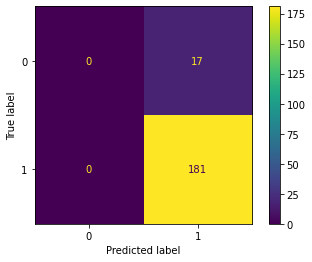

In [48]:
from sklearn.metrics import confusion_matrix

# get accuracy score
accuracy_major = accuracy_score(allY, predsDocCV) #None
print('Testing accuracy of the model is {} %'.format(accuracy_major*100))

# confusion matrix to describe the performance of a classification model
print("Confusion Matrix:")
print(confusion_matrix(allY, predsDocCV)) 
report = classification_report(allY, predsDocCV) 
print(report)

# confusion matrix visualization
ConfusionMatrixDisplay.from_predictions(allY, predsDocCV)
plt.show()


In [49]:
predsTopicCV = foldsRunGLMFiltered(foldTopicCV, allX, allY, 0.05)

Working on fold 1

Training 177
Testing 21
Filtering data
[-0.1846266   0.04167669  0.01504704 ...  0.04577186  0.04711561
 -0.00888101]
Filtering Training Dataset
Original Features Counts: 4019
Output Features Counts: 1607
Filtering Testing Dataset
Original Features Counts: 4019
Output Features Counts: 1607
Building model ...

Working on fold 2

Training 150
Testing 48
Filtering data
[-0.31804103  0.02527668  0.00812214 ...  0.00086175  0.05376347
 -0.0161681 ]
Filtering Training Dataset
Original Features Counts: 4019
Output Features Counts: 1930
Filtering Testing Dataset
Original Features Counts: 4019
Output Features Counts: 1930
Building model ...

Working on fold 3

Training 171
Testing 27
Filtering data
[-0.19853543  0.04944162 -0.01280824 ... -0.02599842  0.04618832
  0.01630335]
Filtering Training Dataset
Original Features Counts: 4019
Output Features Counts: 1508
Filtering Testing Dataset
Original Features Counts: 4019
Output Features Counts: 1508
Building model ...

Working on

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[-0.0695064  -0.02061454  0.02109924 ...  0.03116431  0.04665391
  0.0043614 ]
Filtering Training Dataset
Original Features Counts: 4019
Output Features Counts: 2150
Filtering Testing Dataset
Original Features Counts: 4019
Output Features Counts: 2150
Building model ...

Working on fold 5

Training 164
Testing 34
Filtering data
[-0.22168588  0.03567041 -0.00684114 ... -0.00541206  0.05060405
 -0.04205125]
Filtering Training Dataset
Original Features Counts: 4019
Output Features Counts: 1589
Filtering Testing Dataset
Original Features Counts: 4019
Output Features Counts: 1589
Building model ...



Testing accuracy of the model is 91.41414141414141 %
Confusion Matrix:
[[  0  17]
 [  0 181]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.91      1.00      0.96       181

    accuracy                           0.91       198
   macro avg       0.46      0.50      0.48       198
weighted avg       0.84      0.91      0.87       198



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


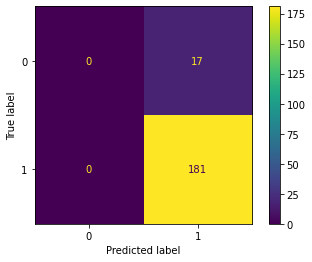

In [50]:
from sklearn.metrics import confusion_matrix

# get accuracy score
accuracy_major = accuracy_score(allY, predsTopicCV) #None
print('Testing accuracy of the model is {} %'.format(accuracy_major*100))

# confusion matrix to describe the performance of a classification model
print("Confusion Matrix:")
print(confusion_matrix(allY, predsTopicCV)) 
report = classification_report(allY, predsTopicCV) 
print(report)

# confusion matrix visualization
ConfusionMatrixDisplay.from_predictions(allY, predsTopicCV)
plt.show()


# Other Evaluation Method

# Model Evaluation (Normal Train Test Split)

Testing accuracy of the model is 96.66666666666667 %
Confusion Matrix:
[[ 0  2]
 [ 0 58]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.97      1.00      0.98        58

    accuracy                           0.97        60
   macro avg       0.48      0.50      0.49        60
weighted avg       0.93      0.97      0.95        60



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


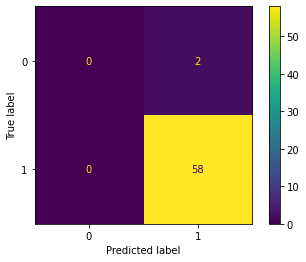

In [51]:
# y_test

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# get accuracy score
accuracy_major = accuracy_score(y_test, y_pred) #None
print('Testing accuracy of the model is {} %'.format(accuracy_major*100))

# confusion matrix to describe the performance of a classification model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred)) 
report = classification_report(y_test, y_pred) 
print(report)

# confusion matrix visualization
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Model Evaluation (SMOTE)

In [57]:
# smote to handle class imbalance problem

sm = SMOTE(random_state = 42)

X_sm, y_sm = sm.fit_resample(hstack([csr_matrix(dense.iloc[:, 3:].to_numpy()), sparse]).toarray(), dense.iloc[:, 0]) #sm.fit_resample(dense.iloc[:, 3:], dense.iloc[:, 0])

print(f'''Shape of X before SMOTE: {allX.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f80638d2ca0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Shape of X before SMOTE: (198, 4019)
Shape of X after SMOTE: (362, 4019)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: y, dtype: float64

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.35, random_state=42
)

In [59]:
cors = computeCorrelaion(X_train, y_train)
threshold = 0.05
print("Training Dataset")
X_train = filter_features(X_train, cors, threshold)
print("Testing Dataset")
X_test =  filter_features(X_test, cors, threshold)

[-0.2705773   0.10580593 -0.10163459 ... -0.0428414   0.12898005
 -0.0017336 ]
Training Dataset
Original Features Counts: 4019
Output Features Counts: 3031
Testing Dataset
Original Features Counts: 4019
Output Features Counts: 3031


/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [60]:
model = LogitNet(n_splits =5)
model = model.fit(X_train, y_train)


In [61]:
y_pred_sm = model.predict(X_test)

y_pred_sm

array([1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1])

Testing accuracy of the model is 90.5511811023622 %
Confusion Matrix:
[[58  2]
 [10 57]]
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        60
           1       0.97      0.85      0.90        67

    accuracy                           0.91       127
   macro avg       0.91      0.91      0.91       127
weighted avg       0.91      0.91      0.91       127



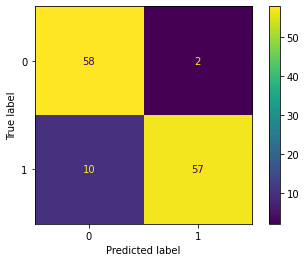

In [62]:
from sklearn.metrics import confusion_matrix

# get accuracy score
accuracy_major = accuracy_score(y_test, y_pred_sm) #None
print('Testing accuracy of the model is {} %'.format(accuracy_major*100))

# confusion matrix to describe the performance of a classification model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_sm)) 
report = classification_report(y_test, y_pred_sm) 
print(report)

# confusion matrix visualization
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_sm)
plt.show()